#Causalidad de Granger: caso IPC e IPRI

Se procede aquí a analizar <ins> el impacto del IPRI sobre el IPC </ins> de forma que se muestre en qué medida la evolución de los precios industriales se traslada a los precios al consumo.

Para ello utilizaremos el concepto de **causalidad de Granger**.

Dicho concepto considera que una serie temporal X (en nuestro caso el IPRI) *causa-granger* una serie temporal Y (en nuestro caso el IPC) si la predicción de Y dados los valores pasados de X e Y es mejor que la predicción de Y dado sólo los valores de Y. Es decir, se dice que X causa-granger Y cuando los valores pasados de X aportan capacidad predictiva.


Con el objetivo de llevarlo a cabo, se realizarán los siguientes pasos:


1.   Cargar el dataset que contiene las series temporales (2002M01-2020M2) de:

> *   IPC: Índice general más los 12 grupos ECOICOP
> *   IPRI: índice general más las 4 secciones en las que se desagrega

2.   Convertir las series (si no lo fueran) es estacionarias - Test Dickey-Fuller.
3. Test de causalidad de Granger.








##Datos

En un primer paso, cargamos los paquetes que se van a utilizar y subimos el dataset con el que vamos a trabajar

In [2]:
#Importamos los paquetes que vamos a usar 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import pyplot #gráficos
from statsmodels.tsa.stattools import adfuller #test dickey-fuller
from statsmodels.tsa.api import VAR #modelo autorregresivo
from statsmodels.tsa.stattools import grangercausalitytests #test de granger



In [3]:
#Cargar el dataset
from google.colab import files
uploaded = files.upload()
dataset = 'causalidad_granger_ipc_ipri.xlsx'
data = pd.read_excel(dataset, sheet_name='Datos', header = 0)

data.head(6)

Saving causalidad_granger_ipc_ipri.xlsx to causalidad_granger_ipc_ipri.xlsx


,año,ipc_general,ipc_alimentos,ipc_bebidas,ipc_vestido,ipc_vivienda,ipc_menaje,ipc_sanidad,ipc_transporte,ipc_comunicaciones,ipc_ocio,ipc_enseñanza,ipc_restaurantes,ipc_otros,ipri_general,ipri_manufacturera,ipri_energia,ipri_agua,ipri_extractivas
0,2002M01,69.530,65.859,46.340,82.717,58.763,81.364,86.313,63.805,128.593,101.553,58.352,63.523,65.705,71.688,75.111,55.917,NaN,77.080
1,2002M02,69.590,65.836,46.348,81.782,58.888,81.475,86.844,64.089,126.667,101.580,58.430,64.123,65.834,71.767,75.279,55.858,NaN,77.163
2,2002M03,70.165,66.185,46.436,83.519,59.041,81.819,87.210,65.007,125.098,103.157,58.496,64.756,66.045,72.165,75.698,55.320,NaN,77.163
3,2002M04,71.118,66.614,48.321,89.456,59.223,82.336,87.665,66.018,125.098,102.658,58.556,65.182,66.185,72.483,76.200,55.141,NaN,77.413
4,2002M05,71.374,66.902,48.446,90.427,59.324,82.686,87.212,66.191,125.098,102.968,58.563,65.416,66.299,72.643,76.284,55.201,NaN,77.330
5,2002M06,71.377,67.075,48.447,89.997,59.470,82.920,87.501,65.545,124.891,103.616,58.571,65.696,66.381,72.404,76.033,55.141,NaN,78.163


In [4]:
#indexamos año

data_1 = data.set_index('año')
data_1.head(6)

,ipc_general,ipc_alimentos,ipc_bebidas,ipc_vestido,ipc_vivienda,ipc_menaje,ipc_sanidad,ipc_transporte,ipc_comunicaciones,ipc_ocio,ipc_enseñanza,ipc_restaurantes,ipc_otros,ipri_general,ipri_manufacturera,ipri_energia,ipri_agua,ipri_extractivas
año,,,,,,,,,,,,,,,,,,
2002M01,69.530,65.859,46.340,82.717,58.763,81.364,86.313,63.805,128.593,101.553,58.352,63.523,65.705,71.688,75.111,55.917,NaN,77.080
2002M02,69.590,65.836,46.348,81.782,58.888,81.475,86.844,64.089,126.667,101.580,58.430,64.123,65.834,71.767,75.279,55.858,NaN,77.163
2002M03,70.165,66.185,46.436,83.519,59.041,81.819,87.210,65.007,125.098,103.157,58.496,64.756,66.045,72.165,75.698,55.320,NaN,77.163
2002M04,71.118,66.614,48.321,89.456,59.223,82.336,87.665,66.018,125.098,102.658,58.556,65.182,66.185,72.483,76.200,55.141,NaN,77.413
2002M05,71.374,66.902,48.446,90.427,59.324,82.686,87.212,66.191,125.098,102.968,58.563,65.416,66.299,72.643,76.284,55.201,NaN,77.330
2002M06,71.377,67.075,48.447,89.997,59.470,82.920,87.501,65.545,124.891,103.616,58.571,65.696,66.381,72.404,76.033,55.141,NaN,78.163


En primer lugar se analizarán únicamente las series ipc_general e ipri_general, para luego proceder a estudiar la casualidad-granger en cada una de las desagregaciones por clases.

##Análisis de los datos y transformación

Una vez se han cargado los datos, para poder aplicar el test de causalidad de Granger, es necesario que las series sean estacionarias.

Las series temporales, teóricamente, se caracterizan por estar formadas por tres componentes: la tendencia (T<sub>t</sub>), la componente estacional (E<sub>t</sub>) y la componente aleatoria (I<sub>t</sub>)

> $X_{t} = T_{t} + E_{t} + I_{t}$


Así, se dice que una serie temporal es **estacionaria** cuando dicha serie se mantiene estable en el tiempo, es decir, cuando la media y la varianza son constantes. Gráficamente puede observarse cuando los valores se mueven alrededor de una media constante y la variabilidad respecto de esa media también es persistente en el tiempo. (1)

¿Y por qué es importante que una serie sea estacionaria? Porque es más fácil de predecir, puesto que si la media y la varianza de mantienen constantes, se considera que hay una gran probabilidad de que en el futuro continuen comportándose de la misma manera.

*Importante: No confundir estacionariedad con estacionalidad.*

###Análisis gráfico

En una primera aproximación se puede observar gráficametente si las series IPC general e IPRI general muestran indicios de no ser estacionarias.

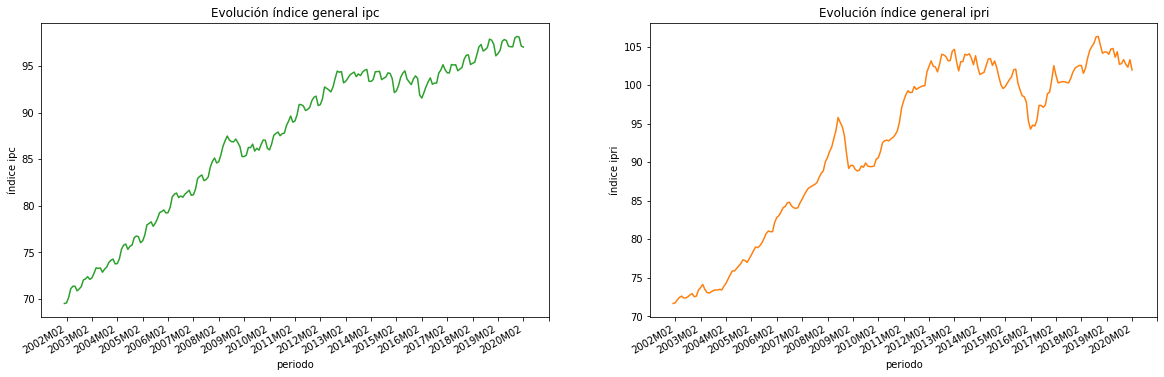

In [5]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,6))

# Especificar las líneas a incluir y su visualización
#gráfico ipc
ax1.plot(data.año, data_1.ipc_general, color='tab:green', label='ipc índice general')

ax1.set_xlabel('periodo')
ax1.set_ylabel('índice ipc')
ax1.set_title('Evolución índice general ipc')

ax1.set_xticks(np.arange(1, 240, step= 12)) #para que no salgan todas las fechas juntas amontonadas (establece saltos entre fecha y fecha)

#gráfico ipri
ax2.plot(data.año, data_1.ipri_general, color='tab:orange', label='ipri índice general')

ax2.set_xlabel('periodo')
ax2.set_ylabel('índice ipri')
ax2.set_title('Evolución índice general ipri')

ax2.set_xticks(np.arange(1, 240, step= 12))

plt.gcf().autofmt_xdate() #para que las fechas salgan inclinadas y no horizontal

Como puede observarse a simple vista, parece que ninguna de las series son estacionarias, pues no muestran una media constante. En ambos casos se observa la presencia de tendencia (un aumento de la media en el tiempo). (2)



###Test de Dickey-Fuller (aumentado)

Para contrastar estos resultados, econométricamente puede comprobarse si una serie es estacionaria o no aplicando el **test de Dickey-Fuller**.

Este test busca determinar la existencia o no de raíces unitarias en una serie temporal. Dicho de otra manera, el test permite conocer, a través de un contraste de hipótesis, si hay presencia significativa de tendencia en la serie temporal.

Dichas hipótesis serían:

*   Hipótesis nula (H<sub>0</sub>): la serie tiene raíz unitaria *(→ la serie no es estacionaria)*
*   Hipótesis alternativa (H<sub>1</sub>): la serie no tiene raíz unitaria *(→  la serie es estacionaria)*

También podrían verse como:

*   H<sub>0</sub>: Hay tendencia estocástica. 
*   H<sub>1</sub>: No hay tendencia estocástica. 





In [6]:
#Comprobamos con el Test Dickey-Fuller
#para la serie temporal del ipc general
resultado_ipc = adfuller(data_1['ipc_general'])
print(f'p-valor: {resultado_ipc[1]}')

if resultado_ipc[1] > 0.05:
    print("La serie no es estacionaria")
else:
    print("La serie es estacionaria")

p-valor: 0.2543024215161528
La serie no es estacionaria


In [7]:
#para la serie temporal del ipri general
resultado_ipri = adfuller(data_1['ipri_general'])
print(f'p-valor: {resultado_ipri[1]}')

if resultado_ipri[1] > 0.05:
    print("La serie no es estacionaria")
else:
    print("La serie es estacionaria")

p-valor: 0.38632849187931484
La serie no es estacionaria


En el caso de las dos variables, el p-valor *(¿Qué tan probables son los datos, asumiendo una hipótesis nula verdadera?)* ha resultado ser mayor que 0.05, por lo que se acepta la hipótesis nula de que hay tendencia estocástica y, por lo tanto, podemos considerar que la serie no es estacionaria.

Como ambas series no son estacionarias, hay que realizar la diferencia para transformarlas en estacionarias.

La diferencia es una forma de transformar un conjunto de datos de series temporales. Se puede emplear para eliminar la dependencia del tiempo. Esto incluye estructuras como tendencias y estacionalidad.

La diferencia se realiza restando la observación anterior de la observación actual.

Se procede a hacer la diferencia de primer orden, para luego, de nuevo, comprobar visual y econométricamente si la transformación ha convertido las series en estacionarias:

###Primera diferencia

In [8]:
#Hacemos la primera diferencia del ipc_general y del ipri_general
serie_transformada = data_1[['ipc_general', 'ipri_general']].diff().dropna()
data = data.iloc[1:]
print(data.shape)
print(serie_transformada.shape)

(217, 19)
(217, 2)


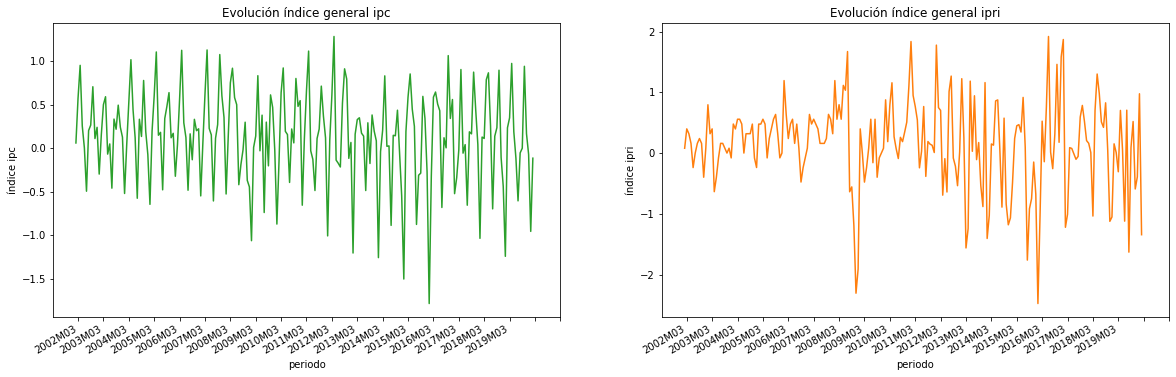

In [9]:
#comprobamos gráficamente el cambio
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,6))

#gráfico ipc
ax1.plot(data.año, serie_transformada.ipc_general, color='tab:green', label='ipc índice general')

ax1.set_xlabel('periodo')
ax1.set_ylabel('índice ipc')
ax1.set_title('Evolución índice general ipc')

ax1.set_xticks(np.arange(1, 240, step= 12)) 

#gráfico ipri
ax2.plot(data.año, serie_transformada.ipri_general, color='tab:orange', label='ipri índice general')

ax2.set_xlabel('periodo')
ax2.set_ylabel('índice ipri')
ax2.set_title('Evolución índice general ipri')

ax2.set_xticks(np.arange(1, 240, step= 12))

plt.gcf().autofmt_xdate() 

In [10]:
#hacemos otra vez el test Dickey-Fuller (para comprobar si con el cambio son estacionarias las series)
resultado_ipc_2 = adfuller(serie_transformada['ipc_general'])
print(f'p-valor: {resultado_ipc_2[1]}')
if resultado_ipc_2[1] > 0.05:
    print("La serie no es estacionaria")
else:
    print("La serie es estacionaria")


p-valor: 0.043337967015050494
La serie es estacionaria


In [11]:
resultado_ipri_2 = adfuller(serie_transformada['ipri_general'])
print(f'p-valor: {resultado_ipri_2[1]}')
if resultado_ipri_2[1] > 0.05:
    print("La serie no es estacionaria")
else:
    print("La serie es estacionaria")

p-valor: 4.6174632694393224e-18
La serie es estacionaria


Con primeras diferencias se consigue estacionalizar las series. No hace falta hacer segundas diferencias.

Ahora se puede proceder a estudiar la causalidad de Granger entre las series temporales IPC general e IPRI general

##Test de Causalidad de Granger

Como se mencionó al principio, la prueba estadística de **causalidad de Granger** sirve para determinar si una serie temporal puede predecir a otra. Así, se sustenta en la idea de que si una serie X causa otra Y, entonces serán mejores predictivamente los modelos de Y que usen retardos de X e Y *(modelo no restringido)*, que aquellos que solo empleen datos retrasados de Y *(modelo restringido)*.

> Modelo restringido: $y_{t} = \beta_{0} + \beta_{1}y_{t-1} + ... + \beta_{p}y_{t-p} + ϵ $

> Modelo no restringido: $y_{t} = \beta_{0} + \beta_{1}y_{t-1} + ... + \beta_{p}y_{t-p} + α_{1}x_{t-1} + ... + α_{p}x_{t-p} + ƞ$

Este concepto fue desarrollado por el Premio Nobel Clive W.J Granger para mejorar la actuación de las predicciones. Es básicamente un test para verificar el uso de una variable en la predicción de otra en una serie temporal multivariante con un determinado retardo (lag).

Así, las hipótesis de dicho test serían:

* Hipótesis nula (H<sub>0</sub>): X<sub>t</sub> no causa-granger Y<sub>t</sub>
* Hipótesis alternativa (H<sub>1</sub>): X<sub>t</sub> causa-granger Y<sub>t</sub>

No obstante, este test tiene limitaciones:

1. No proporciona ninguna visión de relación entre la variable, por lo que no es un "verdadero análisis de causlidad" como podría serlo el análisis "causa-efecto".

2. No se puede aplicar si las series no son estacionarias.

3. La predicción da malos resultados en el caso de que haya interdependencia entre dos o más variables.




Para llevar el test a cabo, primero hay que determinar el número de retardos (lags) óptimos a incluir en la ecuación. Utilizamos para ello el **criterio de información de Akaike (AIC)**. Este criterio en sí mismo proporciona una vía para seleccionar un modelo. Así, dado un conjunto de datos, mide la calidad relativa de un modelo.

Matemáticamente, el caso general se presenta como:

$AIC = 2k - 2ln(L)$

donde k es el número de parámetros del modelo y L es el valor máximo de la función de verosimilitd.

También podría usarse como método para la selección del número de retardos el *Criterio de información Bayesiano (BIC)*.


Cuanto más pequeños es el valor de este criterio mejor, por lo que se consideraría preferible aquel modelo con el menor AIC. El BIC sigue el mismo criterio.

Como con python se puede calcular fácilmente, vamos a emplear ambos criterios a la hora de determinar el número de lags. Con este objetivo, generamos un modelo autoregresivo de los valores conseguidos con la primera diferencia (datos ya estacionarios).



In [12]:
model = VAR(serie_transformada)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)

Lag Order = 1
AIC :  -2.1197143793708504
BIC :  -2.025956645824068
Lag Order = 2
AIC :  -2.1462279379137446
BIC :  -1.989454076140365
Lag Order = 3
AIC :  -3.0988142133947214
BIC :  -2.878610175028806
Lag Order = 4
AIC :  -3.119272725899674
BIC :  -2.8352198668256383
Lag Order = 5
AIC :  -3.226744070750715
BIC :  -2.878419079982865
Lag Order = 6
AIC :  -3.385687026836227
BIC :  -2.972661853990835
Lag Order = 7
AIC :  -3.352476069043327
BIC :  -2.8743178503694025
Lag Order = 8
AIC :  -3.4479544923133747
BIC :  -2.904225475247329
Lag Order = 9
AIC :  -3.4791611045060464
BIC :  -2.8694185707144593
Lag Order = 10
AIC :  -3.562514442065437
BIC :  -2.88631062893913
Lag Order = 11
AIC :  -3.544189456099458
BIC :  -2.801071476661008
Lag Order = 12
AIC :  -3.8854148819030763
BIC :  -3.0749246430888304
Lag Order = 13
AIC :  -3.8375291232489737
BIC :  -2.9592032425255046
Lag Order = 14
AIC :  -3.8174972649174403
BIC :  -2.870866985191215
Lag Order = 15
AIC :  -3.7975861624816676
BIC :  -2.7821772

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Si observamos los datos obtenidos, se puede concluir que el menor AIC y BIC se obtienen en el retardo 12, pues son los valores más pequeños (al ser negativos, se escoge aquel modelo que tiene el valor más negativo).

Así, se procede a realizar el test  de Granger considerando 12 retardos.

In [13]:
#Test de Granger
grangercausalitytests(serie_transformada[['ipc_general', 'ipri_general']], maxlag=12);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3128  , p=0.0221  , df_denom=213, df_num=1
ssr based chi2 test:   chi2=5.3876  , p=0.0203  , df=1
likelihood ratio test: chi2=5.3215  , p=0.0211  , df=1
parameter F test:         F=5.3128  , p=0.0221  , df_denom=213, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5324  , p=0.0118  , df_denom=210, df_num=2
ssr based chi2 test:   chi2=9.2806  , p=0.0097  , df=2
likelihood ratio test: chi2=9.0859  , p=0.0106  , df=2
parameter F test:         F=4.5324  , p=0.0118  , df_denom=210, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=23.2499 , p=0.0000  , df_denom=207, df_num=3
ssr based chi2 test:   chi2=72.1083 , p=0.0000  , df=3
likelihood ratio test: chi2=62.1444 , p=0.0000  , df=3
parameter F test:         F=23.2499 , p=0.0000  , df_denom=207, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=13.2113 , p=0.0000  

Como al menos uno de los p-valor obtenido es muy pequeño (menor que 0.05) rechazamos la hipótesis nula, por lo que consideramos que **IPRI causa-granger IPC**.

Comprobamos también la relación en el otro sentido, para ver si la relación es unidireccional o bidimensional

In [14]:
#Test de Grager
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(serie_transformada[['ipri_general', 'ipc_general']], maxlag=12);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0715  , p=0.0253  , df_denom=213, df_num=1
ssr based chi2 test:   chi2=5.1430  , p=0.0233  , df=1
likelihood ratio test: chi2=5.0827  , p=0.0242  , df=1
parameter F test:         F=5.0715  , p=0.0253  , df_denom=213, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8508  , p=0.0600  , df_denom=210, df_num=2
ssr based chi2 test:   chi2=5.8373  , p=0.0540  , df=2
likelihood ratio test: chi2=5.7595  , p=0.0561  , df=2
parameter F test:         F=2.8508  , p=0.0600  , df_denom=210, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4129  , p=0.0184  , df_denom=207, df_num=3
ssr based chi2 test:   chi2=10.5850 , p=0.0142  , df=3
likelihood ratio test: chi2=10.3315 , p=0.0159  , df=3
parameter F test:         F=3.4129  , p=0.0184  , df_denom=207, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.8361  , p=0.0010  

Como el p-valor que se obtiene es bajo (menor que 0.05) rechazamos la H<sub>0</sub>, lo que significa que **IPC causa-granger IPRI**.

Así consideramos que existe una <ins> relación bidireccional</ins>, donde el IPC viene explicado tanto por sus valores pasados como por los del IPRI, y viceversa.

(donde está casi toda la estructura) https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem/#h2_9

(1) http://www.estadisticas.gobierno.pr/iepr/LinkClick.aspx?fileticket=4_BxecUaZmg%3D

(2) https://estrategiastrading.com/series-estacionarias/